# Multimodal
Combining images with facial action unit activations. 

In [1]:
name_of_this_notebook = 'intermediate_fusion.ipynb'

BATCH_SIZE = 128
LR = 5e-5

experiment_name = f'batch-{BATCH_SIZE}-lr-{LR:.0e}-CROSS-ATTENTION'


In [2]:
import random
import numpy as np
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2024-10-31 22:03:37.300247: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 22:03:37.322406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 22:03:37.322428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 22:03:37.322989: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 22:03:37.326588: I tensorflow/core/platform/cpu_feature_guar

## Prepare Data

In [3]:
from pathlib import Path

dataset_path = Path(r'/home/thor/Desktop/datasets/emoji-hero-multimodal/')

### Prepare FAU Data

In [4]:
import pandas as pd

fau_data_path = dataset_path / 'facial_action_unit_activations'

fau_train_df = pd.read_csv(str(fau_data_path / 'training_set.csv')).sort_values(by='timestamp').reset_index(drop=True)
fau_val_df = pd.read_csv(str(fau_data_path / 'validation_set.csv')).sort_values(by='timestamp').reset_index(drop=True)
fau_test_df = pd.read_csv(str(fau_data_path / 'test_set.csv')).sort_values(by='timestamp').reset_index(drop=True)


def prepare_fau_data(df):
    X = df.iloc[:, 2:-1].values  # All columns except timestamp, participant_id, and label
    y = df.iloc[:, -1].values  # The last column is the label
    return X, y


fau_X_train, fau_y_train = prepare_fau_data(fau_train_df)
fau_X_val, fau_y_val = prepare_fau_data(fau_val_df)
fau_X_test, fau_y_test = prepare_fau_data(fau_test_df)

### Combine FAU with Image Data

Make sure that we have exactly two images (central and 45° side-view) for each FAU activations record. It is expected that there is not data for participant 7 (`<timestamp>-7-<camera-index>.jpg`). 

In [5]:
image_dataset_path = dataset_path / 'images'
image_train_set_path = image_dataset_path / 'training_set'
image_val_set_path = image_dataset_path / 'validation_set'
image_test_set_path = image_dataset_path / 'test_set'


def load_image_paths(image_set_path, fau_df):
    print(f'\nLoading images from {image_set_path}...')
    image_paths = []
    labels = []
    fau_records = []
    for label_dir in image_set_path.iterdir():
        for img_file in label_dir.iterdir():
            timestamp = int(img_file.name.split('-')[0])
            matching_fau = fau_df[fau_df['timestamp'] == timestamp]
            if not matching_fau.empty:
                image_paths.append(str(img_file))
                labels.append(int(label_dir.name))
                fau_records.append(matching_fau.iloc[0, 2:-1].values)
            else:
                print(f'Could not find FAU data for image {img_file.name}')
    print(f'Found {len(image_paths)} images with corresponding fau data in {image_set_path}\n')
    return fau_records, image_paths, labels


fau_train_records, image_train_paths, train_labels = load_image_paths(image_train_set_path, fau_train_df)
fau_val_records, image_val_paths, val_labels = load_image_paths(image_val_set_path, fau_val_df)
fau_test_records, image_test_paths, test_labels = load_image_paths(image_test_set_path, fau_test_df)


Loading images from /home/thor/Desktop/datasets/emoji-hero-multimodal/images/training_set...
Could not find FAU data for image 1700566596617-7-1.jpg
Could not find FAU data for image 1700566771764-7-1.jpg
Could not find FAU data for image 1700566743230-7-0.jpg
Could not find FAU data for image 1700566457312-7-1.jpg
Could not find FAU data for image 1700566609011-7-0.jpg
Could not find FAU data for image 1700566596617-7-0.jpg
Could not find FAU data for image 1700566743230-7-1.jpg
Could not find FAU data for image 1700566785956-7-1.jpg
Could not find FAU data for image 1700566785956-7-0.jpg
Could not find FAU data for image 1700566471449-7-1.jpg
Could not find FAU data for image 1700566457312-7-0.jpg
Could not find FAU data for image 1700566771764-7-0.jpg
Could not find FAU data for image 1700566609011-7-1.jpg
Could not find FAU data for image 1700566577455-7-1.jpg
Could not find FAU data for image 1700566471449-7-0.jpg
Could not find FAU data for image 1700566577455-7-0.jpg
Could not 

In [6]:
import tensorflow as tf

IMAGE_SIZE = (224, 224)


def parse_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image


def load_combined_data(fau_records, image_paths, labels, batch_size, reshuffle_each_iteration):
    fau_dataset = tf.data.Dataset.from_tensor_slices(fau_records)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    image_dataset = image_dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip(((image_dataset, fau_dataset), label_dataset))

    dataset = dataset.shuffle(buffer_size=len(fau_records), seed=SEED,
                              reshuffle_each_iteration=reshuffle_each_iteration)
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


train_dataset = load_combined_data(fau_train_records, image_train_paths, train_labels, BATCH_SIZE, True)
val_dataset = load_combined_data(fau_val_records, image_val_paths, val_labels, BATCH_SIZE, False)
test_dataset = load_combined_data(fau_test_records, image_test_paths, test_labels, BATCH_SIZE, False)


2024-10-31 22:03:38.853537: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-10-31 22:03:38.853551: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: ubu-pcgh
2024-10-31 22:03:38.853553: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: ubu-pcgh
2024-10-31 22:03:38.853627: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.183.1
2024-10-31 22:03:38.853635: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.183.1
2024-10-31 22:03:38.853637: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.183.1


### Prepare Class Frequencies for Loss Function 

In [7]:
id_to_emotion = {
    0: 'Neutral',
    1: 'Happy',
    2: 'Sad',
    3: 'Surprise',
    4: 'Fear',
    5: 'Disgust',
    6: 'Anger',
}

class_frequencies = fau_train_df['Label'].value_counts()
print(f'--- Training Set Class Frequencies ---')
for class_id, frequency in class_frequencies.items():
    print(f'{class_id} - {id_to_emotion[class_id]:<9} : {frequency:>8}')

inverse_class_frequencies = 1 / class_frequencies
normalized_inverse_class_frequencies = inverse_class_frequencies / inverse_class_frequencies.sum()
class_weights = normalized_inverse_class_frequencies.to_dict()
print('\nClass Weights:\n', class_weights)

--- Training Set Class Frequencies ---
0 - Neutral   :      197
1 - Happy     :      191
3 - Surprise  :      172
2 - Sad       :      131
4 - Fear      :      105
5 - Disgust   :      102
6 - Anger     :       66

Class Weights:
 {0: 0.08716123123128974, 1: 0.08989928037991667, 3: 0.09983001484048884, 2: 0.13107452330201588, 4: 0.16353107192918173, 5: 0.16834080933886353, 6: 0.26016306897824365}


## Define Network Architecture

### Load Pretrained Models

In [8]:
from tensorflow.keras.models import load_model

models_base_path = Path(r'/home/thor/Desktop/repos/emoji-hero-baseline')

img_model_path = models_base_path / '2_image' / 'emojihero_transfer_imagenet_20240320-1526' / 'best_model_phase_5.keras'
fau_model_path = models_base_path / '1_face_expressions' / '20241031-1748-checkpoint-batch-32-lr-1e-03_val_8155_test_7169' / 'fau_model.keras'

img_model = load_model(str(img_model_path))
fau_model = load_model(str(fau_model_path))

In [9]:
img_test_dataset = test_dataset.map(lambda inputs, labels: (inputs[0], labels))
img_loss, img_accuracy = img_model.evaluate(img_test_dataset)
print(f'Image Model - Test Loss: {img_loss}, Test Accuracy: {img_accuracy}')

6/6 [==============================] - 6s 831ms/step - loss: 1.5114 - accuracy: 0.6984
Image Model - Test Loss: 1.5113863945007324, Test Accuracy: 0.6984127163887024


In [10]:
fau_test_dataset = test_dataset.map(lambda inputs, labels: (inputs[1], labels))
fau_loss, fau_accuracy = fau_model.evaluate(fau_test_dataset)
print(f'FAU Model - Test Loss: {fau_loss}, Test Accuracy: {fau_accuracy}')

6/6 [==============================] - 0s 4ms/step - loss: 0.9676 - accuracy: 0.7169
FAU Model - Test Loss: 0.967613935470581, Test Accuracy: 0.7169312238693237


In [11]:
def print_layers(model):
    num_layers = len(model.layers)
    for i, layer in enumerate(model.layers):
        print((num_layers - i), layer.name, layer.__class__.__name__)



In [12]:
print_layers(img_model)

242 input_1 InputLayer
241 sequential Sequential
240 rescaling Rescaling
239 normalization Normalization
238 rescaling_1 Rescaling
237 stem_conv_pad ZeroPadding2D
236 stem_conv Conv2D
235 stem_bn BatchNormalization
234 stem_activation Activation
233 block1a_dwconv DepthwiseConv2D
232 block1a_bn BatchNormalization
231 block1a_activation Activation
230 block1a_se_squeeze GlobalAveragePooling2D
229 block1a_se_reshape Reshape
228 block1a_se_reduce Conv2D
227 block1a_se_expand Conv2D
226 block1a_se_excite Multiply
225 block1a_project_conv Conv2D
224 block1a_project_bn BatchNormalization
223 block2a_expand_conv Conv2D
222 block2a_expand_bn BatchNormalization
221 block2a_expand_activation Activation
220 block2a_dwconv_pad ZeroPadding2D
219 block2a_dwconv DepthwiseConv2D
218 block2a_bn BatchNormalization
217 block2a_activation Activation
216 block2a_se_squeeze GlobalAveragePooling2D
215 block2a_se_reshape Reshape
214 block2a_se_reduce Conv2D
213 block2a_se_expand Conv2D
212 block2a_se_excite M

In [13]:
print_layers(fau_model)

6 fau_input InputLayer
5 dense Dense
4 fau_dropout_1 Dropout
3 dense_1 Dense
2 fau_dropout_2 Dropout
1 dense_2 Dense


In [14]:
from keras.src.layers import Concatenate
from keras.src.initializers.initializers import GlorotUniform
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.layers import Layer


@register_keras_serializable()
class CrossAttention(Layer):
    def __init__(self, units_v1, units_v2):
        super(CrossAttention, self).__init__()
        self.units_v1 = units_v1
        self.units_v2 = units_v2
        self.weight_layer_v1 = Dense(units_v1, activation='sigmoid', kernel_initializer=GlorotUniform())
        self.weight_layer_v2 = Dense(units_v2, activation='sigmoid', kernel_initializer=GlorotUniform())

    def call(self, inputs, training=False):
        v1, v2 = inputs

        weights_v1 = self.weight_layer_v1(v2)
        weights_v2 = self.weight_layer_v2(v1)

        weighted_v1 = weights_v1 * v1
        weighted_v2 = weights_v2 * v2

        return [weighted_v1, weighted_v2]

In [15]:
from keras.src.layers import BatchNormalization, Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model


print(img_model.layers[-3])
img_features = img_model.layers[-3].output
img_feature_model = Model(inputs=img_model.input, outputs=img_features)

print(fau_model.layers[-5])
fau_features = fau_model.layers[-5].output
fau_feature_model = Model(inputs=fau_model.input, outputs=fau_features)

img_feature_model.trainable = False
fau_feature_model.trainable = False

img_features = Dropout(0.2, seed=SEED)(img_features)
fau_features = Dropout(0.1, seed=SEED)(fau_features)
img_features = Dense(512, activation='relu', name='scale_img')(img_features)
fau_features = Dense(512, activation='relu', name='scale_fau')(fau_features)
img_features = BatchNormalization()(img_features)
fau_features = BatchNormalization()(fau_features)
img_features, fau_features = CrossAttention(512, 512)([img_features, fau_features])
img_features = Flatten()(img_features)
fau_features = Flatten()(fau_features)

combined_features = Concatenate()([img_features, fau_features])
combined_features = Dropout(0.4, name='dropout_1_after_fusion')(combined_features)
combined_features = Dense(len(class_frequencies), activation='softmax', name='final_output')(combined_features)

combined_model = Model(inputs=[img_feature_model.input, fau_feature_model.input], outputs=combined_features)
combined_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['sequential[0][0]']          
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                        

## Train the Network

In [16]:
import datetime
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
checkpoint_dir = Path(f'{timestamp}-checkpoint-{experiment_name}')
checkpoint_loss = ModelCheckpoint(filepath=f'{checkpoint_dir / "best_model_by_loss"}.keras',
                                  save_weights_only=False,
                                  monitor='val_loss',
                                  mode='min',
                                  save_best_only=True)
checkpoint_acc = ModelCheckpoint(filepath=f'{checkpoint_dir / "best_model"}.keras',
                                 save_weights_only=False,
                                 monitor='val_accuracy',
                                 mode='max',
                                 save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', patience=16, restore_best_weights=True)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.2, patience=6, min_lr=1e-6)

callbacks = [checkpoint_loss, checkpoint_acc, early_stopping_callback, reduce_lr_callback]

optimizer = Adam(learning_rate=LR)

combined_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
history = combined_model.fit(train_dataset,
                             validation_data=val_dataset,
                             class_weight=class_weights,
                             callbacks=callbacks,
                             epochs=400)

Epoch 1/400
16/16 [==============================] - 24s 1s/step - loss: 0.2415 - accuracy: 0.2863 - val_loss: 1.7363 - val_accuracy: 0.5221 - lr: 5.0000e-05
Epoch 2/400
16/16 [==============================] - 20s 1s/step - loss: 0.1291 - accuracy: 0.7376 - val_loss: 1.5514 - val_accuracy: 0.6792 - lr: 5.0000e-05
Epoch 3/400
16/16 [==============================] - 20s 1s/step - loss: 0.0813 - accuracy: 0.8828 - val_loss: 1.4185 - val_accuracy: 0.7143 - lr: 5.0000e-05
Epoch 4/400
16/16 [==============================] - 20s 1s/step - loss: 0.0574 - accuracy: 0.9238 - val_loss: 1.3192 - val_accuracy: 0.7208 - lr: 5.0000e-05
Epoch 5/400
16/16 [==============================] - 20s 1s/step - loss: 0.0464 - accuracy: 0.9357 - val_loss: 1.2369 - val_accuracy: 0.7286 - lr: 5.0000e-05
Epoch 6/400
16/16 [==============================] - 20s 1s/step - loss: 0.0373 - accuracy: 0.9575 - val_loss: 1.1642 - val_accuracy: 0.7416 - lr: 5.0000e-05
Epoch 7/400
16/16 [==============================] -

Max Training accuracy: 0.9958506226539612
val_loss: 0.568899393081665 in epoch 60, val_accuracy: 0.8285714387893677 in epoch 63


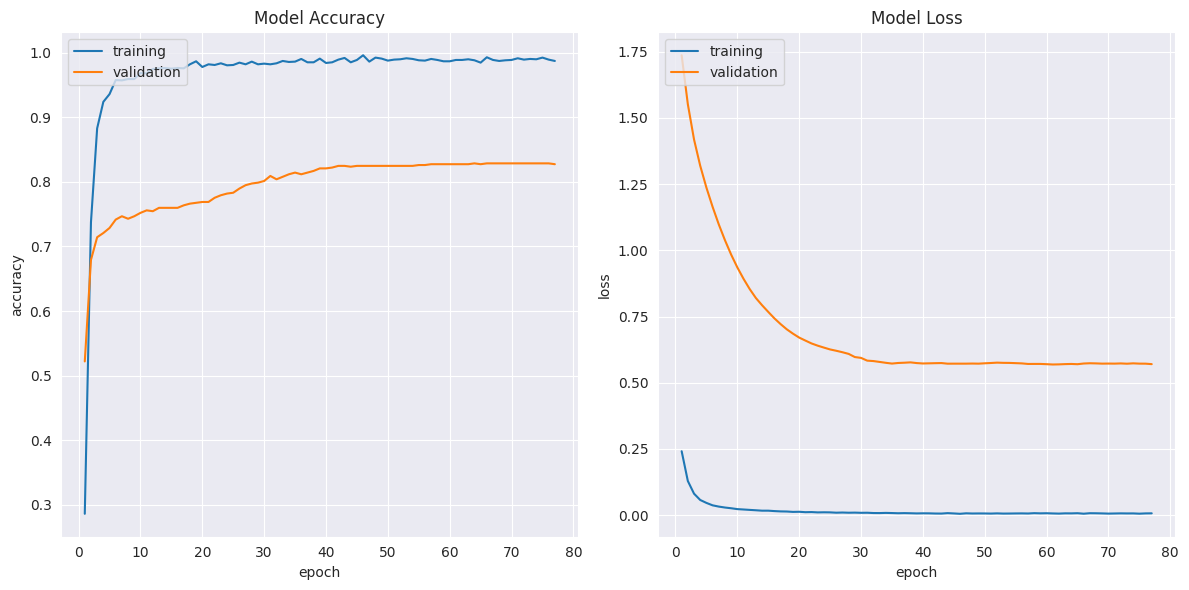

In [18]:
import matplotlib.pyplot as plt


def plot_and_save_combined_history(hist, checkpoint_dir):
    acc = hist.history["accuracy"]
    val_acc = hist.history["val_accuracy"]
    loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]

    print(f'Max Training accuracy: {max(acc)}')
    print(
        f'val_loss: {min(val_loss)} in epoch {val_loss.index(min(val_loss))}, val_accuracy: {max(val_acc)} in epoch {val_acc.index(max(val_acc))}')

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="training")
    plt.plot(epochs, val_acc, label="validation")
    plt.title("Model Accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="training")
    plt.plot(epochs, val_loss, label="validation")
    plt.title("Model Loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")

    plt.tight_layout()

    plt.savefig(str(checkpoint_dir / 'training_history.png'))

    plt.show()


plot_and_save_combined_history(history, checkpoint_dir)

In [19]:
from tensorflow.keras.models import load_model

best_checkpoint_by_loss = str(checkpoint_dir / "best_model_by_loss.keras")
best_checkpoint_by_acc = str(checkpoint_dir / "best_model.keras")
best_model_by_loss = load_model(best_checkpoint_by_loss, safe_mode=False)
best_model_by_acc = load_model(best_checkpoint_by_acc, safe_mode=False)

In [20]:
import numpy as np
from sklearn.metrics import classification_report

y_pred_vectors_val = best_model_by_loss.predict(val_dataset)
y_pred_val = np.argmax(y_pred_vectors_val, axis=1)
y_true_val = np.concatenate([y for _, y in val_dataset], axis=0)

report = classification_report(y_true_val, y_pred_val, target_names=id_to_emotion.values(), digits=4)
print(report)

7/7 [==============================] - 6s 704ms/step
              precision    recall  f1-score   support

     Neutral     0.7826    0.9818    0.8710       110
       Happy     0.8560    0.9727    0.9106       110
         Sad     0.7786    0.9273    0.8465       110
    Surprise     0.9352    0.9182    0.9266       110
        Fear     0.8298    0.7091    0.7647       110
     Disgust     0.7407    0.7273    0.7339       110
       Anger     0.9242    0.5545    0.6932       110

    accuracy                         0.8273       770
   macro avg     0.8353    0.8273    0.8209       770
weighted avg     0.8353    0.8273    0.8209       770



[[108   2   0   0   0   0   0]
 [  3 107   0   0   0   0   0]
 [  4   0 102   0   0   4   0]
 [  0   1   0 101   8   0   0]
 [ 10   9   0   7  78   6   0]
 [  3   4  10   0   8  80   5]
 [ 10   2  19   0   0  18  61]]


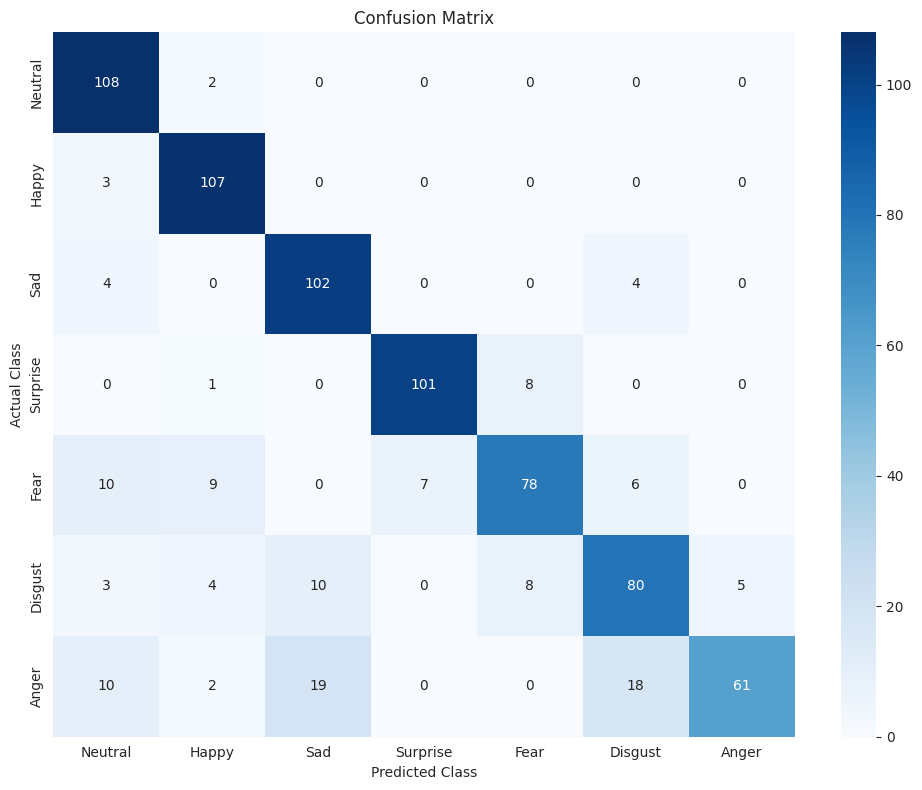

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred):
    class_names = id_to_emotion.values()

    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.tight_layout()
    plt.show()

    return fig


val_cm = plot_confusion_matrix(y_true_val, y_pred_val)

## Evaluate Model

In [22]:
test_loss_loss_model, test_acc_loss_model = best_model_by_loss.evaluate(test_dataset)
print(f"Test accuracy of best model by val_loss: {test_acc_loss_model}")

test_loss_acc_model, test_acc_acc_model = best_model_by_acc.evaluate(test_dataset)
print(f"Test accuracy of best model by val_acc: {test_acc_acc_model}")

6/6 [==============================] - 6s 832ms/step - loss: 0.7518 - accuracy: 0.8029
Test accuracy of best model by val_loss: 0.8029100298881531
6/6 [==============================] - 6s 822ms/step - loss: 0.7522 - accuracy: 0.8042
Test accuracy of best model by val_acc: 0.8042327761650085


In [23]:
best_model = best_model_by_acc

In [24]:
y_pred_vectors = best_model.predict(test_dataset)
y_pred = np.argmax(y_pred_vectors, axis=1)
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

report = classification_report(y_true, y_pred, target_names=id_to_emotion.values(), digits=4)
print(report)

6/6 [==============================] - 6s 825ms/step
              precision    recall  f1-score   support

     Neutral     0.8475    0.9259    0.8850       108
       Happy     0.8092    0.9815    0.8870       108
         Sad     0.9111    0.7593    0.8283       108
    Surprise     0.9072    0.8148    0.8585       108
        Fear     0.7652    0.8148    0.7892       108
     Disgust     0.6638    0.7130    0.6875       108
       Anger     0.7528    0.6204    0.6802       108

    accuracy                         0.8042       756
   macro avg     0.8081    0.8042    0.8022       756
weighted avg     0.8081    0.8042    0.8022       756



[[100   4   2   0   0   1   1]
 [  0 106   0   0   1   0   1]
 [  9   0  82   0   1   3  13]
 [  0   0   0  88  20   0   0]
 [  3   4   0   7  88   6   0]
 [  0  15   4   2   3  77   7]
 [  6   2   2   0   2  29  67]]


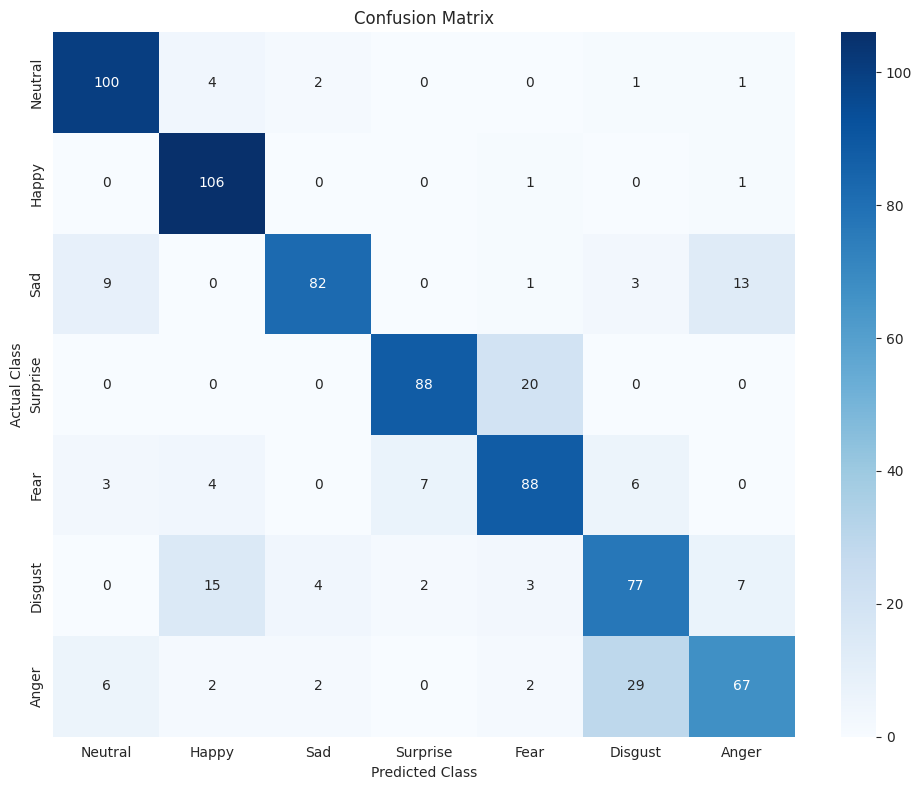

In [25]:
cm_figure = plot_confusion_matrix(y_true, y_pred)

In [26]:
def save_evaluation_results(report, cm_figure, checkpoint_dir):
    with (checkpoint_dir / 'classification_report.txt').open(mode='w') as f:
        f.write(report)
    cm_figure.savefig(str(checkpoint_dir / 'confusion_matrix.png'))


save_evaluation_results(report, cm_figure, checkpoint_dir)

In [27]:
import time

time.sleep(5)

In [28]:
import shutil

shutil.copy2((Path() / name_of_this_notebook), (checkpoint_dir / name_of_this_notebook))

PosixPath('20241031-2203-checkpoint-batch-128-lr-5e-05-CROSS-ATTENTION/multimodal_pretrained_inter_fusion.ipynb')